# CVaR Portfolio Optimization

The goal of this project is to build a **long-only equity portfolio** that **minimizes Conditional Value-at-Risk (CVaR)** at level Beta. To train the portfolio on **2019** daily returns, then **evaluate** the same allocation on **2020**, and compare to a benchmark (**NDX**) as a single-asset portfolio.

## Setup & Load

In [1]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum

prices_2019 = pd.read_csv("../data/stocks2019.csv", index_col = 0, parse_dates = True)
prices_2020 = pd.read_csv("../data/stocks2020.csv", index_col = 0, parse_dates = True)

C:\Users\dhaji\AppData\Local\Temp\ipykernel_14996\3898608343.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  prices_2020 = pd.read_csv("stocks2020.csv", index_col = 0, parse_dates = True)


In [2]:
prices_2019[:3]

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715


In [3]:
prices_2020[:3]

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
2020-01-02,8872.219727,58.266792,334.429993,49.099998,107.839996,283.679993,1368.680054,1367.369995,1898.010010,231.917572,...,36.970001,254.550003,196.729996,150.167465,219.449997,56.046688,167.460007,64.771545,60.782249,100.115349
2020-01-03,8793.900391,58.286655,331.809998,48.599998,106.410004,280.440002,1361.520020,1360.660034,1874.969971,230.343124,...,36.180000,250.169998,200.880005,151.628220,217.979996,56.046688,168.440002,63.774597,61.074562,97.810677
2020-01-06,8848.519531,59.349670,333.709991,48.389999,106.580002,285.880005,1397.810059,1394.209961,1902.880005,232.110748,...,35.689999,250.949997,202.740005,151.976013,224.029999,56.530506,169.490005,62.550629,60.986866,95.771927


## Convert prices --> returns & define the investable universe

**Goal**
- Convert daily prices to **arithmetic daily returns**
- Keep 'NDX' aside as a **benchmark** and **exclude it** from investable assets
- Keep only tickers present in **BOTH** years to be robust to missing names/delistings

In [4]:
# convert prices to arithmetic daily returns and drop the initial NaNs
rets_2019_all = prices_2019.pct_change().dropna(how = "all")
rets_2020_all = prices_2020.pct_change().dropna(how = "all")

# separate benchmark series; exclude it from investable universe
index_col = "NDX"
if index_col not in rets_2019_all or index_col not in rets_2020_all:
    raise ValueError(f"expected benchmark column '{index_col}' missing from csvs")

ndx_2019 = rets_2019_all[index_col].dropna()
ndx_2020 = rets_2020_all[index_col].dropna()

# investable = everything except the index column
inv_2019 = rets_2019_all.drop(columns = [index_col]).dropna(axis = 1, how = "any")
inv_2020 = rets_2020_all.drop(columns = [index_col]).dropna(axis = 1, how = "any")

# align the investable tickers across years (intersection)
common_cols = sorted(set(inv_2019.columns) & set(inv_2020.columns))
if len(common_cols) == 0:
    raise ValueError("no common investable tickers across 2019 and 2020")

rets_2019 = inv_2019[common_cols].dropna()
rets_2020 = inv_2020[common_cols].dropna()

# small helper to print percents nicely
def as_pct(x):
    return 100.0 * float(x)

We want a **long-only** portfolio that minimizes tail risk measured by **CVar** at level Beta. CVaR is the **average loss** in the worst (1-Beta) fraction of days.
Daily **loss** on day \(k\) for weights \(x\) and returns \(y_k\): \(L_k = -x^\top y_k\).
- Decision variables: \(x\) (weights), \(\alpha\) (VaR threshold), \(u_k\) (tail slacks).

**Linear Program (Rockafellar–Uryasev):**


## Solve for the weights on the 2019 training sample

Optimize x to minimize Beta-CVaR on 2019 with a long-only budget and daily expected return floor, R.  
We’ll return the weights, VaR (alpha), and CVaR (objective value).

In [5]:
def solve_cvar_min_long_only(returns_df, beta=0.95, min_return=0.0002, quiet=True):
    """
    minimize beta-CVaR of daily losses (Rockafellar-Uryasev LP) on a training sample.

    returns:
        dict with:
          - 'x': pd.Series of optimal weights (sorted descending)
          - 'VaR': optimal alpha (daily VaR at level beta)
          - 'CVaR': optimal objective value (daily CVaR at level beta)
          - 'model': gurobi model (if you want diagnostics)
    """
    # matrices
    Y = returns_df.values              # shape: q x n (rows: days, cols: assets)
    q, n = Y.shape
    mu = returns_df.mean(axis = 0).values  # mean daily returns per asset

    # build model
    m = Model("min_cvar")
    if quiet:
        m.Params.OutputFlag = 0  # silence solver log

    # decision variables
    x = m.addVars(n, lb = 0.0, name = "x")                 # long-only weights
    alpha = m.addVar(lb = -GRB.INFINITY, name = "alpha")   # VaR threshold
    u = m.addVars(q, lb = 0.0, name = "u")                 # tail slack variables

    # VaR + average tail loss --> the objective
    inv_tail_mass = 1.0 / ((1.0 - beta) * q)
    m.setObjective(alpha + inv_tail_mass * quicksum(u[k] for k in range(q)), GRB.MINIMIZE)

    # tail constraints: u_k >= -x^T y_k - alpha  (excess loss above VaR)
    for k in range(q):
        m.addConstr(u[k] >= -quicksum(Y[k, j] * x[j] for j in range(n)) - alpha, name = f"tail_{k}")

    # fully invested, long-only
    m.addConstr(quicksum(x[j] for j in range(n)) == 1.0, name = "budget")

    # small daily expected return floor
    m.addConstr(quicksum(mu[j] * x[j] for j in range(n)) >= min_return, name = "min_return")

    # optimize
    m.optimize()

    # collect solution
    x_series = pd.Series([x[j].X for j in range(n)], index = returns_df.columns, name = "weight")
    x_series = x_series.sort_values(ascending = False)
    return {"x": x_series, "VaR": alpha.X, "CVaR": m.objVal, "model": m}


## Re-evaluate CVaR on new data for a fixed portfolio

Hold x fixed (from 2019) and compute VaR/CVaR on 2020 by optimizing only alpha and u. This isolates out-of-sample risk for the same allocation

In [6]:
def evaluate_cvar_fixed_weights(returns_df, weights, beta = 0.95, quiet = True):
    
    # align weights to columns
    w = weights.reindex(returns_df.columns).fillna(0.0).values
    Y = returns_df.values
    q, n = Y.shape

    # daily portfolio losses for the fixed weights
    losses = -Y.dot(w)

    # build eval model
    m = Model("eval_cvar_fixed_x")
    if quiet:
        m.Params.OutputFlag = 0

    alpha = m.addVar(lb = -GRB.INFINITY, name = "alpha")
    u = m.addVars(q, lb = 0.0, name = "u")

    inv_tail_mass = 1.0 / ((1.0 - beta) * q)
    m.setObjective(alpha + inv_tail_mass * quicksum(u[k] for k in range(q)), GRB.MINIMIZE)

    # tail constraints for the realized losses
    for k in range(q):
        m.addConstr(u[k] >= float(losses[k]) - alpha, name = f"tail_eval_{k}")

    m.optimize()
    return {"VaR": alpha.X, "CVaR": m.objVal}

## Compute benchmark CVaR for single series (NDX)

Treat NDX like a one-asset portfolio with weight 1. Compute its VaR/CVaR on each year

In [8]:
def evaluate_cvar_single_series(series_returns, beta = 0.95, quiet = True):

    losses = -series_returns.dropna().values  # loss = -return
    q = losses.shape[0]

    m = Model("eval_cvar_single")
    if quiet:
        m.Params.OutputFlag = 0

    alpha = m.addVar(lb = -GRB.INFINITY, name = "alpha")
    u = m.addVars(q, lb = 0.0, name = "u")

    inv_tail_mass = 1.0 / ((1.0 - beta) * q)
    m.setObjective(alpha + inv_tail_mass * quicksum(u[k] for k in range(q)), GRB.MINIMIZE)

    for k in range(q):
        m.addConstr(u[k] >= float(losses[k]) - alpha, name=f"tail_single_{k}")

    m.optimize()
    return {"VaR": alpha.X, "CVaR": m.objVal}

## Run experiment (Beta = 0.95)
- Train on 2019 with Beta = 0.95 and R = 0.02% daily
- Report in-sample (2019) and out-of-sample (2020) VaR/CVaR
- Compare with NDX for both years
- Print top weights

In [9]:
beta_values   = [0.95]   # later: [0.90, 0.95, 0.99] for sensitivity analysis
min_daily_ret = 0.0002   # 0.02% minimum expected daily return

experiment_out = []
for beta in beta_values:
    # 1) train: learn weights on 2019
    train = solve_cvar_min_long_only(rets_2019, beta = beta, min_return = min_daily_ret, quiet = True)
    w_star = train["x"]

    # 2) evaluate: fixed weights on 2019 (in-sample) and 2020 (out-of-sample)
    ins = evaluate_cvar_fixed_weights(rets_2019, w_star, beta = beta, quiet = True)
    oos = evaluate_cvar_fixed_weights(rets_2020, w_star, beta = beta, quiet = True)

    # 3) benchmark: NDX alone in both periods
    ndx_2019_stats = evaluate_cvar_single_series(ndx_2019, beta = beta, quiet = True)
    ndx_2020_stats = evaluate_cvar_single_series(ndx_2020, beta = beta, quiet = True)

    print(f"\n=== beta = {beta:.2f} ===")
    print(f"in-sample  (2019)  VaR = {as_pct(ins['VaR']):.4f}%   CVaR = {as_pct(ins['CVaR']):.4f}%")
    print(f"out-of-sample(2020) VaR = {as_pct(oos['VaR']):.4f}%   CVaR = {as_pct(oos['CVaR']):.4f}%")
    print(f"NDX 2019            VaR = {as_pct(ndx_2019_stats['VaR']):.4f}%   CVaR = {as_pct(ndx_2019_stats['CVaR']):.4f}%")
    print(f"NDX 2020            VaR = {as_pct(ndx_2020_stats['VaR']):.4f}%   CVaR = {as_pct(ndx_2020_stats['CVaR']):.4f}%")

    # show top allocations for interpretability
    top5 = w_star.head(5)
    print("\nTop-5 weights:")
    for t, w in top5.items():
        print(f"  {t:<10s} {as_pct(w):6.2f}%")

    experiment_out.append({
        "beta": beta,
        "weights": w_star,
        "ins": ins,
        "oos": oos,
        "ndx2019": ndx_2019_stats,
        "ndx2020": ndx_2020_stats
    })

Set parameter Username
Set parameter LicenseID to value 2699652
Academic license - for non-commercial use only - expires 2026-08-25

=== beta = 0.95 ===
in-sample  (2019)  VaR = 0.8500%   CVaR = 1.1090%
out-of-sample(2020) VaR = 2.5389%   CVaR = 4.6563%
NDX 2019            VaR = 1.6209%   CVaR = 2.4743%
NDX 2020            VaR = 3.9098%   CVaR = 5.6495%

Top-5 weights:
  XEL         30.39%
  CHTR        26.50%
  AMGN         8.08%
  CTXS         6.56%
  CHKP         6.27%


## Results & Interpretation (β = 0.95)

Running the CVaR optimization on 2019 returns gave the following:

- **In-sample (2019)**  
  - Portfolio VaR ≈ **0.85%** and CVaR ≈ **1.11%**  
  - Benchmark NDX VaR ≈ **1.62%** and CVaR ≈ **2.47%**  
  - → The optimized portfolio cuts tail risk roughly in half compared to the index.

- **Out-of-sample (2020)**  
  - Portfolio VaR ≈ **2.54%** and CVaR ≈ **4.66%**  
  - Benchmark NDX VaR ≈ **3.91%** and CVaR ≈ **5.65%**  
  - → Tail risk rose sharply in the pandemic year, but the optimized portfolio still offered protection relative to the index.

- **Top allocations (2019 solution)**  
  - XEL ~30%  
  - CHTR ~27%  
  - AMGN ~8%  
  - CTXS ~7%  
  - CHKP ~6%  
____________________________________________________________________________________________
- The optimizer concentrated heavily in a few defensive or stable-growth names (utilities like XEL, healthcare like AMGN, and tech with steady cash flows). This reflects the model’s focus on minimizing downside rather than diversifying broadly.
- The sharp rise in CVaR from 2019 to 2020 highlights **non-stationarity**: risk patterns change when the market regime shifts. A portfolio that looks “safe” in one year can still be hit hard in an unprecedented shock like COVID.
- Even so, the portfolio consistently dominated the benchmark on CVaR, showing that **systematic risk control pays off**, even if it can’t fully shield against extreme environments.

### β Sensitivity

Check how different values of β (0.90, 0.95, 0.99) change the portfolio and its risk.  
- Lower β looks at a bigger part of the loss tail.  
- Higher β focuses only on the very worst losses.  
 
1. Train the model on 2019 for each β.  
2. Measure CVaR and VaR in 2019 and 2020.  
3. Look at how the portfolio weights shift.


In [10]:
# run β-sensitivity on 2019 and evaluate on 2020
beta_grid = [0.90, 0.95, 0.99]
min_daily_ret = 0.0002  # 0.02% daily

beta_results = []
weights_by_beta = {}

for beta in beta_grid:
    # optimize on 2019
    fit = solve_cvar_min_long_only(rets_2019, beta=beta, min_return=min_daily_ret, quiet=True)
    w_star = fit["x"]
    weights_by_beta[beta] = w_star

    # evaluate with fixed weights
    ins = evaluate_cvar_fixed_weights(rets_2019, w_star, beta=beta, quiet=True)
    oos = evaluate_cvar_fixed_weights(rets_2020, w_star, beta=beta, quiet=True)

    beta_results.append({
        "beta": beta,
        "ins_VaR_%":  as_pct(ins["VaR"]),
        "ins_CVaR_%": as_pct(ins["CVaR"]),
        "oos_VaR_%":  as_pct(oos["VaR"]),
        "oos_CVaR_%": as_pct(oos["CVaR"]),
    })

# pretty print summary table
print("β-sensitivity — CVaR/VaR summary (daily %)")
print("-" * 60)
for row in beta_results:
    print(f"β={row['beta']:.2f} | 2019: VaR {row['ins_VaR_%']:.3f}%  CVaR {row['ins_CVaR_%']:.3f}%"
          f"  |  2020: VaR {row['oos_VaR_%']:.3f}%  CVaR {row['oos_CVaR_%']:.3f}%")

# show top-5 weights per β (helps see allocation shifts)
print("\nTop-5 weights per β:")
for beta in beta_grid:
    print(f"\nβ = {beta:.2f}")
    top5 = weights_by_beta[beta].head(5)
    for t, w in top5.items():
        print(f"  {t:<10s} {as_pct(w):6.2f}%")

# optional: build a quick comparison frame of the top allocations across β
# (keeps only tickers that appear in any β's top-8 for readability)
top_universe = set()
for beta in beta_grid:
    top_universe |= set(weights_by_beta[beta].head(8).index)
top_universe = sorted(top_universe)

alloc_table = pd.DataFrame({
    f"β={beta:.2f}": weights_by_beta[beta].reindex(top_universe).fillna(0.0).map(as_pct)
    for beta in beta_grid
}, index=top_universe).sort_index()

print("\nAllocation comparison (percent weights) for union of top-8 tickers across β:")
display(alloc_table.round(2))

β-sensitivity — CVaR/VaR summary (daily %)
------------------------------------------------------------
β=0.90 | 2019: VaR 0.487%  CVaR 0.890%  |  2020: VaR 1.489%  CVaR 3.270%
β=0.95 | 2019: VaR 0.850%  CVaR 1.109%  |  2020: VaR 2.539%  CVaR 4.656%
β=0.99 | 2019: VaR 1.245%  CVaR 1.245%  |  2020: VaR 7.660%  CVaR 9.369%

Top-5 weights per β:

β = 0.90
  CHTR        24.06%
  XEL         21.30%
  MDLZ        13.66%
  EXC          6.43%
  WBA          5.29%

β = 0.95
  XEL         30.39%
  CHTR        26.50%
  AMGN         8.08%
  CTXS         6.56%
  CHKP         6.27%

β = 0.99
  XEL         44.70%
  CHTR        24.81%
  CTXS         8.91%
  KHC          6.73%
  NTES         5.10%

Allocation comparison (percent weights) for union of top-8 tickers across β:


,β=0.90,β=0.95,β=0.99
AMGN,4.80,8.08,3.63
CHKP,1.83,6.27,0.00
CHTR,24.06,26.50,24.81
CSX,0.00,3.43,0.00
CTXS,4.73,6.56,8.91
DXCM,0.48,0.00,0.82
EBAY,4.87,2.35,0.00
EXC,6.43,5.22,0.00
KHC,1.47,4.05,6.73
MDLZ,13.66,0.00,0.00


### Part 4 — Minimize Maximum Monthly CVaR (2019)

Instead of minimizing the *average* daily CVaR for the year, minimize the **worst month’s CVaR**.  
This way the portfolio is built to handle the toughest month, not just the average year.

1. Split 2019 into months.  
2. For each month, calculate CVaR with its own VaR/slack variables.  
3. Add a variable `z` that is at least as big as every month’s CVaR.  
4. Minimize `z` to shrink the worst month’s risk.  

- Portfolio weights for this “min-max” approach.  
- The CVaR for each month.  
- Compare to the Part 2 (average CVaR) portfolio.


In [11]:
from collections import OrderedDict

def minimize_max_monthly_cvar_2019(returns_df, beta=0.95, min_return=0.0002, quiet=True):
    """
    Minimize the maximum monthly beta-CVaR across 2019.
    Shared weights x across the year; each month has its own alpha_m and u_{m,k}.
    """
    # split 2019 by month (keep only months with data)
    month_keys = returns_df.index.to_period("M")
    months = sorted(month_keys.unique())
    monthly_returns = OrderedDict()
    for m in months:
        mask = (month_keys == m)
        Rm = returns_df.loc[mask]
        if len(Rm) > 0:
            monthly_returns[str(m)] = Rm

    # dimensions
    tickers = list(returns_df.columns)
    n = len(tickers)

    # precompute means for min-return constraint (use full-year mean; could also use month-weighted)
    mu = returns_df.mean(axis=0).values

    # build model
    m = Model("min_max_monthly_cvar")
    if quiet:
        m.Params.OutputFlag = 0

    # decision variables
    x = m.addVars(n, lb=0.0, name="x")                 # weights (long-only)
    z = m.addVar(lb=-GRB.INFINITY, name="z")           # upper bound on monthly CVaR (objective)

    # per-month variables
    alpha = {}     # VaR per month
    u = {}         # slacks per day in each month
    coeff = {}     # 1/((1-beta)*q_m) per month
    for mi, (mname, Rm) in enumerate(monthly_returns.items()):
        q_m, _ = Rm.shape
        alpha[mname] = m.addVar(lb=-GRB.INFINITY, name=f"alpha[{mname}]")
        u[mname] = m.addVars(q_m, lb=0.0, name=f"u[{mname}]")
        coeff[mname] = 1.0 / ((1.0 - beta) * q_m)

    # objective: minimize z (the max monthly CVaR)
    m.setObjective(z, GRB.MINIMIZE)

    # monthly tail constraints + z >= monthly CVaR
    for mname, Rm in monthly_returns.items():
        Y = Rm.values
        q_m, _ = Y.shape

        # u_{m,k} >= -x^T y_{m,k} - alpha_m
        for k in range(q_m):
            m.addConstr(u[mname][k] >= -quicksum(Y[k, j]*x[j] for j in range(n)) - alpha[mname],
                        name=f"tail[{mname},{k}]")

        # z >= alpha_m + coeff_m * sum_k u_{m,k}
        m.addConstr(z >= alpha[mname] + coeff[mname] * quicksum(u[mname][k] for k in range(q_m)),
                    name=f"z_ge_monthcvar[{mname}]")

    # budget and min expected return (full-year mean)
    m.addConstr(quicksum(x[j] for j in range(n)) == 1.0, name="budget")
    m.addConstr(quicksum(mu[j]*x[j] for j in range(n)) >= min_return, name="min_return")

    # solve
    m.optimize()

    # collect solution
    x_star = pd.Series([x[j].X for j in range(n)], index=tickers, name="weight").sort_values(ascending=False)
    z_star = z.X

    # compute realized monthly CVaR values at optimum (for reporting)
    month_cvars = OrderedDict()
    for mname, Rm in monthly_returns.items():
        q_m = len(Rm)
        # objective piece for month m at solution
        alpha_m = alpha[mname].X
        u_vals = np.array([u[mname][k].X for k in range(q_m)], dtype=float)
        month_cvars[mname] = alpha_m + coeff[mname] * u_vals.sum()

    return {"weights": x_star, "z": z_star, "monthly_cvars": month_cvars, "model": m}

# ---- run Part 4 at β = 0.95 ----
beta_p4 = 0.95
min_daily_ret = 0.0002

p4 = minimize_max_monthly_cvar_2019(rets_2019, beta=beta_p4, min_return=min_daily_ret, quiet=True)

# For context, also get the average-CVaR solution from Part 2 (same β), if not already available
avg_sol = solve_cvar_min_long_only(rets_2019, beta=beta_p4, min_return=min_daily_ret, quiet=True)

# print results
print(f"Part 4 — Minimize MAX monthly CVaR (β={beta_p4:.2f})")
print(f"Objective (max monthly CVaR): {as_pct(p4['z']):.4f}%\n")

print("Monthly CVaR values (percent):")
for mname, cvar in p4["monthly_cvars"].items():
    print(f"  {mname}: {as_pct(cvar):.4f}%")

print("\nTop-5 weights (min-max monthly CVaR solution):")
for t, w in p4["weights"].head(5).items():
    print(f"  {t:<10s} {as_pct(w):6.2f}%")

print("\nComparison point — Part 2 (minimize average CVaR on 2019):")
print(f"  Average CVaR objective: {as_pct(avg_sol['CVaR']):.4f}%")
print("  Top-5 weights (average-CVaR solution):")
for t, w in avg_sol["x"].head(5).items():
    print(f"    {t:<10s} {as_pct(w):6.2f}%")

Part 4 — Minimize MAX monthly CVaR (β=0.95)
Objective (max monthly CVaR): 1.2446%

Monthly CVaR values (percent):
  2019-01: 0.9288%
  2019-02: 1.2446%
  2019-03: 0.7252%
  2019-04: 0.9585%
  2019-05: 1.0831%
  2019-06: 1.2259%
  2019-07: 1.2446%
  2019-08: 1.2446%
  2019-09: 1.2446%
  2019-10: 1.2446%
  2019-11: 1.0914%
  2019-12: 1.2446%

Top-5 weights (min-max monthly CVaR solution):
  XEL         45.03%
  CHTR        24.35%
  CTXS         8.97%
  KHC          6.73%
  NTES         5.11%

Comparison point — Part 2 (minimize average CVaR on 2019):
  Average CVaR objective: 1.1090%
  Top-5 weights (average-CVaR solution):
    XEL         30.39%
    CHTR        26.50%
    AMGN         8.08%
    CTXS         6.56%
    CHKP         6.27%


### Part 5 - Rolling Monthly Re-Optimization in 2020

Update the portfolio **each month in 2020** using the **previous 12 months** of daily returns, then evaluate that month’s tail risk.

1. For month `M` in 2020, train on `[M−11, …, M]` (12 months of daily returns).  
2. Solve CVaR (β=0.95, R=0.02%) → get weights for month `M`.  
3. Evaluate **that fixed portfolio** on the **days of month `M`** → monthly CVaR for `M`.  
4. Repeat for all 12 months in 2020.  
5. Summarize **average**, **std dev**, **min**, and **max** of monthly CVaR and compare with Part 2’s single (static) portfolio.


In [12]:
# --- helpers for time windows and rolling training ---

# we already have rets_2019, rets_2020 with the same columns
# combine 2019+2020 for easy 12-month windows
rets_all = pd.concat([rets_2019, rets_2020]).sort_index()

def month_range(series, year):
    """Return list of (month_string 'YYYY-MM', mask_index) for each month in `year`."""
    per = series.index.to_period("M")
    months = sorted({p for p in per if p.year == year})
    out = []
    for p in months:
        mask = (per == p)
        out.append((str(p), mask))
    return out

def trailing_12m_mask(series, end_month_str):
    """Mask for the 12-month trailing window ending at end_month_str (inclusive)."""
    end_p = pd.Period(end_month_str, freq="M")
    start_p = end_p - 11  # 12 months total
    per = series.index.to_period("M")
    return (per >= start_p) & (per <= end_p)

# --- rolling monthly optimization in 2020 ---

beta_rolling = 0.95
min_daily_ret = 0.0002

months_2020 = month_range(rets_all, 2020)  # [('2020-01', mask), ...]
tickers = rets_all.columns

weights_by_month = {}     # month -> pd.Series weights
cvar_by_month = {}        # month -> float monthly CVaR (daily β-CVaR computed on that month’s days)
var_by_month = {}         # optional: monthly VaR for reference

for m_str, month_mask in months_2020:
    # 12-month trailing training window ending at m_str
    train_mask = trailing_12m_mask(rets_all, m_str)
    train_df = rets_all.loc[train_mask, tickers]
    
    # optimize CVaR on the trailing window
    sol = solve_cvar_min_long_only(train_df, beta=beta_rolling, min_return=min_daily_ret, quiet=True)
    x_m = sol["x"]
    weights_by_month[m_str] = x_m
    
    # evaluate the fixed weights on the current month only
    month_df = rets_all.loc[month_mask, tickers]
    eval_m = evaluate_cvar_fixed_weights(month_df, x_m, beta=beta_rolling, quiet=True)
    cvar_by_month[m_str] = eval_m["CVaR"]
    var_by_month[m_str]  = eval_m["VaR"]

# --- summarize monthly CVaR stats for the rolling strategy ---
import numpy as np
months = list(cvar_by_month.keys())
cvars = np.array([cvar_by_month[m] for m in months], dtype=float)

avg_cvar = float(cvars.mean())
std_cvar = float(cvars.std(ddof=0))
min_cvar = float(cvars.min())
max_cvar = float(cvars.max())

print("Rolling re-optimization (2020, β=0.95)")
print("Monthly CVaR stats (daily %):")
print(f"  Average: {as_pct(avg_cvar):.4f}%")
print(f"  Stdev  : {as_pct(std_cvar):.4f}%")
print(f"  Min    : {as_pct(min_cvar):.4f}%")
print(f"  Max    : {as_pct(max_cvar):.4f}%")

# build a small table for the report
rolling_table = pd.DataFrame({
    "VaR_%":  [as_pct(var_by_month[m])  for m in months],
    "CVaR_%": [as_pct(cvar_by_month[m]) for m in months],
}, index=months)
print("\nMonthly VaR/CVaR for the rolling portfolios (daily %):")
display(rolling_table.round(3))

# --- comparison: static Part 2 portfolio evaluated month-by-month in 2020 ---
# if you already solved Part 2 as `train = solve_cvar_min_long_only(rets_2019, ...)`:
static_x = solve_cvar_min_long_only(rets_2019, beta=beta_rolling, min_return=min_daily_ret, quiet=True)["x"]

static_cvar_by_month = {}
for m_str, month_mask in months_2020:
    month_df = rets_all.loc[month_mask, tickers]
    eval_static = evaluate_cvar_fixed_weights(month_df, static_x, beta=beta_rolling, quiet=True)
    static_cvar_by_month[m_str] = eval_static["CVaR"]

static_cvars = np.array([static_cvar_by_month[m] for m in months], dtype=float)
print("\nStatic (2019-trained) portfolio CVaR by month in 2020 (daily %):")
static_table = pd.DataFrame({"CVaR_%": [as_pct(x) for x in static_cvars]}, index=months)
display(static_table.round(3))

print("\nSummary comparison (daily %):")
print(f"Rolling  — Avg {as_pct( avg_cvar):.3f}% | Std {as_pct( std_cvar):.3f}% | Min {as_pct( min_cvar):.3f}% | Max {as_pct( max_cvar):.3f}%")
print(f"Static   — Avg {as_pct(static_cvars.mean()):.3f}% | Std {as_pct(static_cvars.std(ddof=0)): .3f}% | "
      f"Min {as_pct(static_cvars.min()):.3f}% | Max {as_pct(static_cvars.max()):.3f}%")

Rolling re-optimization (2020, β=0.95)
Monthly CVaR stats (daily %):
  Average: 2.5360%
  Stdev  : 1.3967%
  Min    : 0.8492%
  Max    : 6.6311%

Monthly VaR/CVaR for the rolling portfolios (daily %):


,VaR_%,CVaR_%
2020-01,0.849,0.849
2020-02,3.203,3.203
2020-03,4.713,6.631
2020-04,2.154,2.672
2020-05,1.928,1.928
2020-06,0.826,1.987
2020-07,1.080,2.394
2020-08,1.400,1.569
2020-09,2.737,3.277
2020-10,2.122,2.168



Static (2019-trained) portfolio CVaR by month in 2020 (daily %):


,CVaR_%
2020-01,0.814
2020-02,3.611
2020-03,10.831
2020-04,3.281
2020-05,2.074
2020-06,3.254
2020-07,1.370
2020-08,1.636
2020-09,2.572
2020-10,2.708



Summary comparison (daily %):
Rolling  — Avg 2.536% | Std 1.397% | Min 0.849% | Max 6.631%
Static   — Avg 2.929% | Std  2.533% | Min 0.814% | Max 10.831%


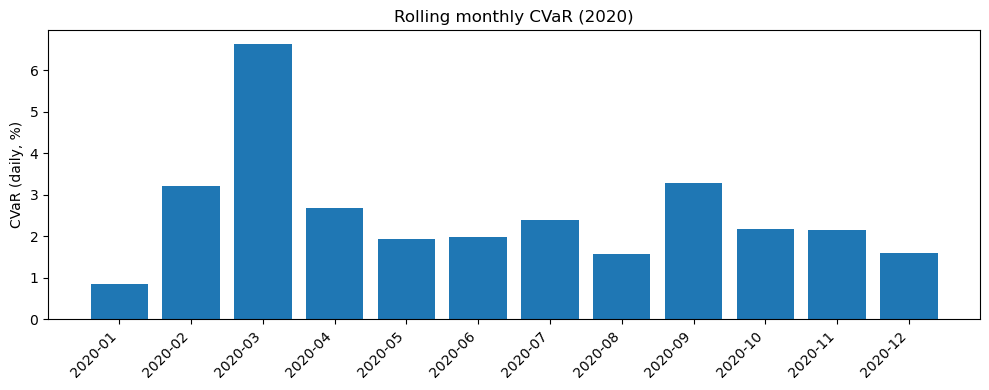

In [14]:
# 1) Rolling monthly CVaR in 2020 (bar chart)
import matplotlib.pyplot as plt
import numpy as np

rolling_cvar_pct = np.array([x * 100.0 for x in cvars])  # already in order of `months`

plt.figure(figsize=(10, 4))
plt.bar(range(len(months)), rolling_cvar_pct)
plt.xticks(range(len(months)), months, rotation=45, ha="right")
plt.ylabel("CVaR (daily, %)")
plt.title("Rolling monthly CVaR (2020)")
plt.tight_layout()
plt.show()

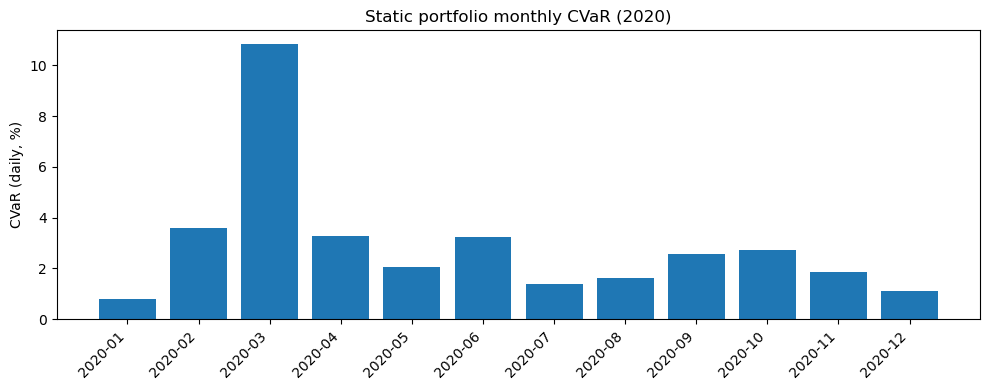

In [15]:
# 2) Static (2019-trained) portfolio CVaR by month in 2020 (bar chart)
import matplotlib.pyplot as plt
import numpy as np

static_cvar_pct = np.array([x * 100.0 for x in static_cvars])

plt.figure(figsize=(10, 4))
plt.bar(range(len(months)), static_cvar_pct)
plt.xticks(range(len(months)), months, rotation=45, ha="right")
plt.ylabel("CVaR (daily, %)")
plt.title("Static portfolio monthly CVaR (2020)")
plt.tight_layout()
plt.show()

### Part 6 — Stability Check (≤ 5 percentage-point change)

See if the **month-to-month** weight change for **each asset** stays within **0.05** (5 percentage points).  
If not stable, describe how to enforce it (you don’t have to solve a new model).

- Compute `|x_i^(m) − x_i^(m−1)|` for each asset `i` and month transition.  
- Flag violations where the change > 0.05.  
- Summarize how many assets/months violate the rule and which tickers move the most.

_______________________________________________________________________________________________________________________________________________________
- Add constraints **per asset, per month**: `−0.05 ≤ x_i^(m) − x_i^(m−1) ≤ 0.05`.  
- If you also want a total turnover limit, add `∑_i |x_i^(m) − x_i^(m−1)| ≤ τ` with standard linearization using split variables.


In [13]:
# build a weight matrix (tickers x months) from Part 5 results
# weights_by_month: dict month -> Series

months = sorted(weights_by_month.keys())
W = pd.DataFrame({m: weights_by_month[m].reindex(tickers).fillna(0.0) for m in months})
W = W.loc[tickers]  # ensure consistent order

# compute month-to-month absolute changes
dW = W.diff(axis=1).abs().iloc[:, 1:]  # changes from month 2 onward
dW.index.name = "Ticker"
dW.columns.name = "Month"

# summarize stability
threshold = 0.05
violations = (dW > threshold)

total_cells = dW.size
num_violations = int(violations.sum().sum())
pct_violations = 100.0 * num_violations / total_cells

stable_by_month = (~violations).all(axis=0)  # True if ALL tickers within threshold for that transition
stable_all = bool(stable_by_month.all())

print("Stability check (≤ 5 percentage points per asset, month-to-month):")
print(f"  Total transitions checked: {total_cells}")
print(f"  Violations: {num_violations}  ({pct_violations:.2f}% of asset-month pairs)")
print(f"  Is the sequence fully stable?  {stable_all}")
print("\nShare of assets within 5pp by month transition:")
share_ok = 100.0 * (~violations).mean(axis=0)
display(share_ok.to_frame("Pct_assets_within_5pp").round(1))

print("\nTop 10 largest month-to-month changes (any ticker, any transition):")
# stack, sort, show biggest movers
big_moves = dW.stack().sort_values(ascending=False).head(10)
display(big_moves.to_frame("Abs_change").round(4))

Stability check (≤ 5 percentage points per asset, month-to-month):
  Total transitions checked: 1100
  Violations: 43  (3.91% of asset-month pairs)
  Is the sequence fully stable?  False

Share of assets within 5pp by month transition:


,Pct_assets_within_5pp
Month,
2020-02,95.0
2020-03,91.0
2020-04,95.0
2020-05,96.0
2020-06,98.0
2020-07,96.0
2020-08,92.0
2020-09,95.0
2020-10,99.0



Top 10 largest month-to-month changes (any ticker, any transition):


Abs_change
Ticker Month              
CTXS   2020-03      0.4517
XEL    2020-03      0.3321
CHTR   2020-03      0.2967
COST   2020-08      0.2900
CTXS   2020-04      0.2043
COST   2020-09      0.1959
CTXS   2020-05      0.1958
EBAY   2020-08      0.1677
       2020-04      0.1583
GILD   2020-03      0.1548

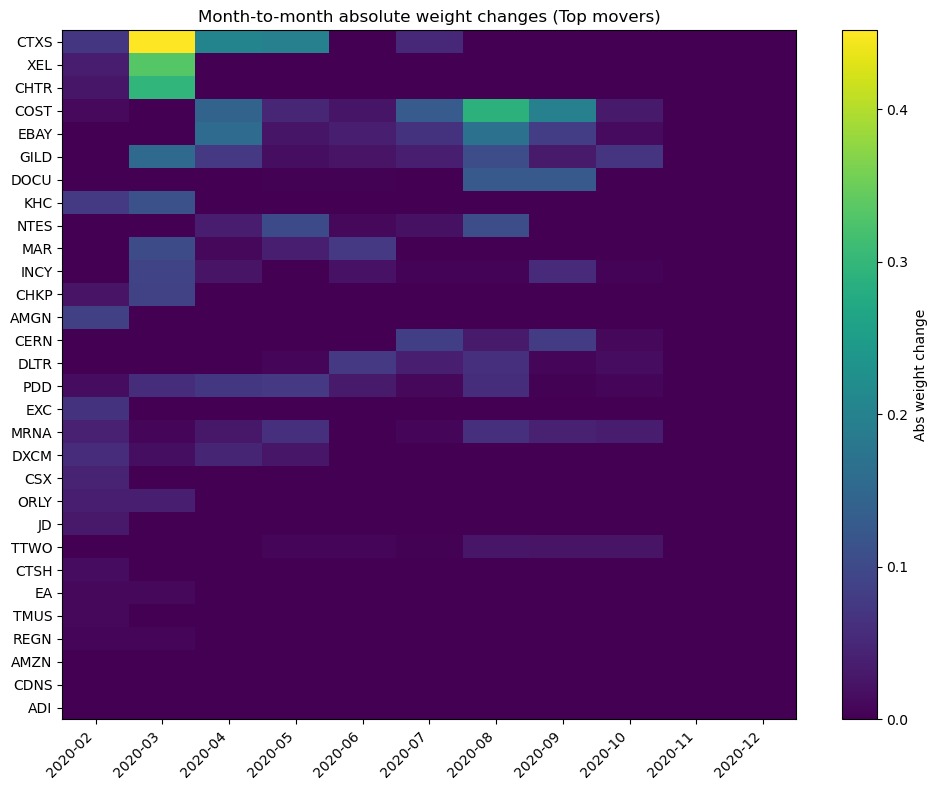

In [16]:
# Heatmap of |Δ weights| (tickers x month-transitions)
import matplotlib.pyplot as plt
import numpy as np

# Optionally focus on the top movers to keep the plot readable:
max_change_by_ticker = dW.max(axis=1)
top_n = 30  # change to None for all tickers
if top_n is not None and top_n < len(max_change_by_ticker):
    top_tickers = max_change_by_ticker.sort_values(ascending=False).head(top_n).index
    dW_plot = dW.loc[top_tickers]
else:
    dW_plot = dW

plt.figure(figsize=(10, 8))
plt.imshow(dW_plot.values, aspect="auto")  # default colormap
plt.colorbar(label="Abs weight change")
plt.yticks(range(dW_plot.shape[0]), dW_plot.index)
plt.xticks(range(dW_plot.shape[1]), dW_plot.columns, rotation=45, ha="right")
plt.title("Month-to-month absolute weight changes (Top movers)")
plt.tight_layout()
plt.show()